In [1]:
pip install phik 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --pre --extra-index https://pypi.anaconda.org/scientific-python-nightly-wheels/simple scikit-learn

Looking in indexes: https://pypi.org/simple, https://pypi.anaconda.org/scientific-python-nightly-wheels/simple
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import seaborn as sns
import numpy as np
import phik
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler,  MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from phik import phik_matrix
from phik.report import plot_correlation_matrix

plt.rcParams["figure.figsize"] = (15,10)

## Цель

Задача 1: предсказание уровня удовлетворённости сотрудника
    
Задача 2: предсказание увольнения сотрудника из компании

Для этой задачи заказчик предоставил данные с признаками:
* id — уникальный идентификатор сотрудника;
* dept — отдел, в котором работает сотрудник;
* level — уровень занимаемой должности;
* workload — уровень загруженности сотрудника;
* employment_years — длительность работы в компании (в годах);
* last_year_promo — показывает, было ли повышение за последний год;
* last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
* supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
* salary — ежемесячная зарплата сотрудника;
* job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Задача 1

In [8]:
RANDOM_STATE = 42
TEST_SIZE = 25

### Шаг 1. Загрузка данных

#### train_job_satisfaction_rate

In [11]:
train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [12]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [13]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Таблица содержит 4000 строк с информацией об условиях труда работника, некоторые из них имеют пропуски. Это тренировочная выборка с входными и целевым признаками

#### test_features

In [16]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [17]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Таблица содержит 2000 строк, некоторые имеют пропуски

#### test_target_job_satisfaction_rate

In [20]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [21]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Таблица содержит 2000 строк, пропусков нет

### Шаг 2. Предобработка данных

#### train_job_satisfaction_rate

In [26]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [27]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [28]:
train_job_satisfaction_rate.duplicated().sum()

0

In [29]:
for column in train_job_satisfaction_rate.columns:
    print(train_job_satisfaction_rate[column].unique())

[155278 653870 184592 ... 533318 706868 338347]
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
[ 2  1  4  7  9  6  3 10  8  5]
['no' 'yes']
['no' 'yes']
[1 5 2 3 4]
[24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800
 78000 88800 92400 85200 91200 98400 96000 97200]
[0.58 0.76 0.11 0.37 0.2  0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57
 0.16 0.69 0.33 0.64 0.39 0.8  0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22
 0.23 0.5  0.35 0.3  0.77 0.88 0.59 0.21 0.36 0.85 0.7  0.48 0.6  0.1
 0.27 0.71 0.86 0.54 0.73 0.46 0.31 0.72 0.51 0.61 0.81 0.99 0.15 0.91
 0.68 0.4  0.89 0.67 0.75 0.98 0.26 0.45 0.92 0.82 0.66 0.55 0.38 0.53

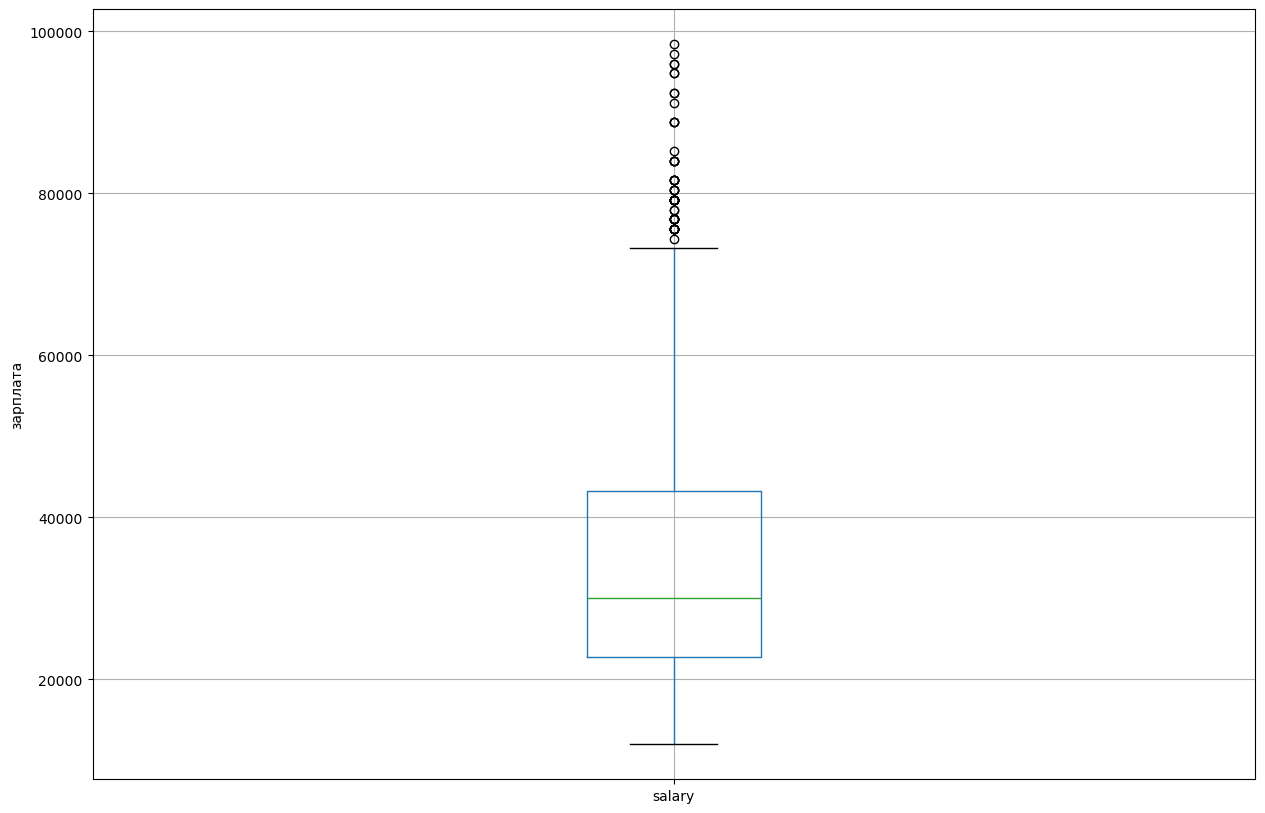

In [30]:
train_job_satisfaction_rate.boxplot(column='salary')
plt.ylabel('зарплата')
plt.show()

In [34]:
train_job_satisfaction_rate.query('salary > 75000').count()/train_job_satisfaction_rate['salary'].count()

id                       0.01475
dept                     0.01475
level                    0.01475
workload                 0.01475
employment_years         0.01475
last_year_promo          0.01475
last_year_violations     0.01475
supervisor_evaluation    0.01475
salary                   0.01475
job_satisfaction_rate    0.01475
dtype: float64

#### test_features

In [36]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [37]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [38]:
test_features.duplicated().sum()

0

In [39]:
for column in test_features.columns:
    print(test_features[column].unique())

[485046 686555 467458 ... 305653 160233 771859]
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
[ 2  1  5  6  3  9  7  4  8 10]
['no' 'yes']
['no' 'yes']
[5 4 3 1 2]
[28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]


In [40]:
test_features.query('salary > 75000').count()/test_features['salary'].count()

id                       0.0195
dept                     0.0195
level                    0.0195
workload                 0.0195
employment_years         0.0195
last_year_promo          0.0195
last_year_violations     0.0195
supervisor_evaluation    0.0195
salary                   0.0195
dtype: float64

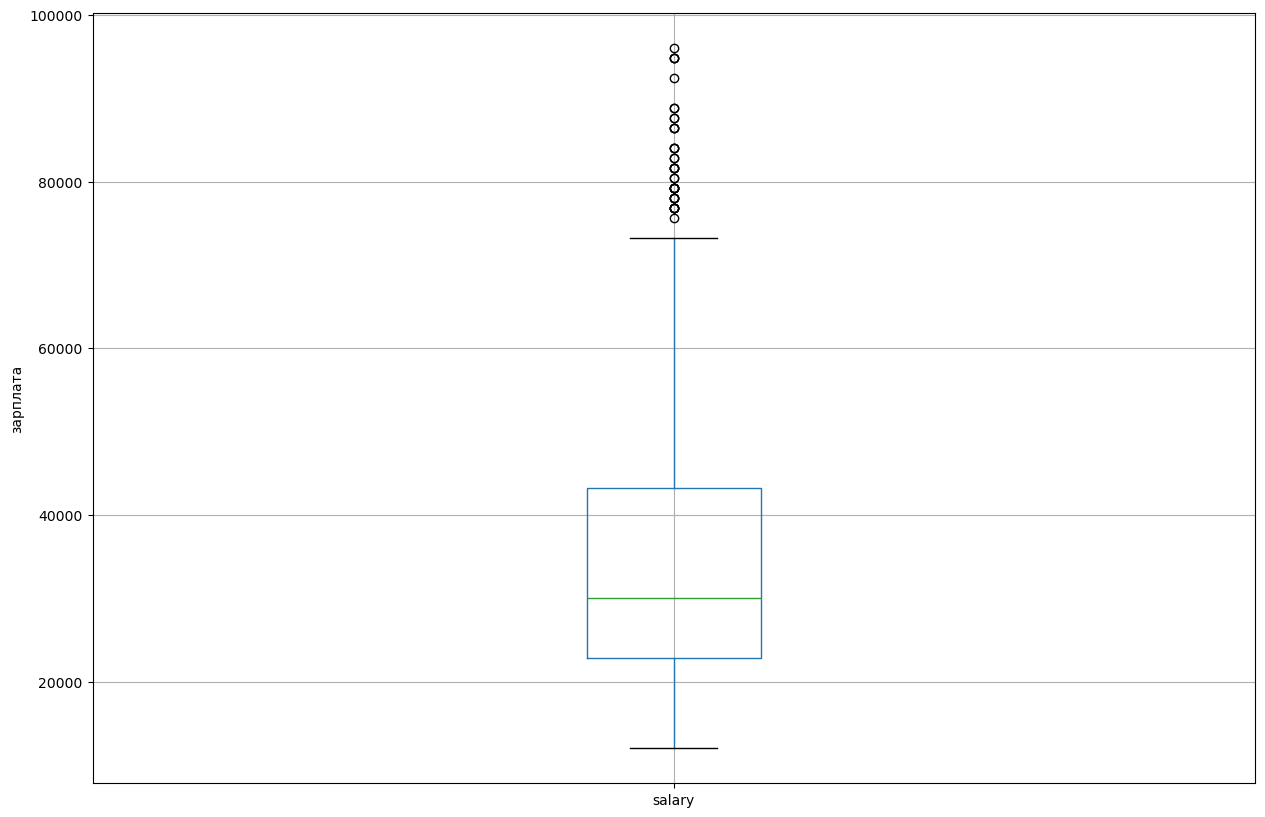

In [41]:
test_features.boxplot(column='salary')
plt.ylabel('зарплата')
plt.show()

#### test_target_job_satisfaction_rate

In [44]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [45]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [46]:
test_target_job_satisfaction_rate.duplicated().sum()

0

#### Вывод

В ходе предобработки были проверены пропуски, которые будут заполнены в дальнейшем, так же были проверены типы данных, выбросы, дубликаты

### Исследовательский анализ данных

#### train_job_satisfaction_rate

In [52]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [54]:
train_job_satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [55]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [56]:
num = ['salary', 'job_satisfaction_rate']
cat = ['dept', 'level', 'workload', 'employment_years', 
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation']

train_job_satisfaction_rate[num].hist(bins=15, figsize=(15,5))
plt.ylabel('количество')
plt.show()

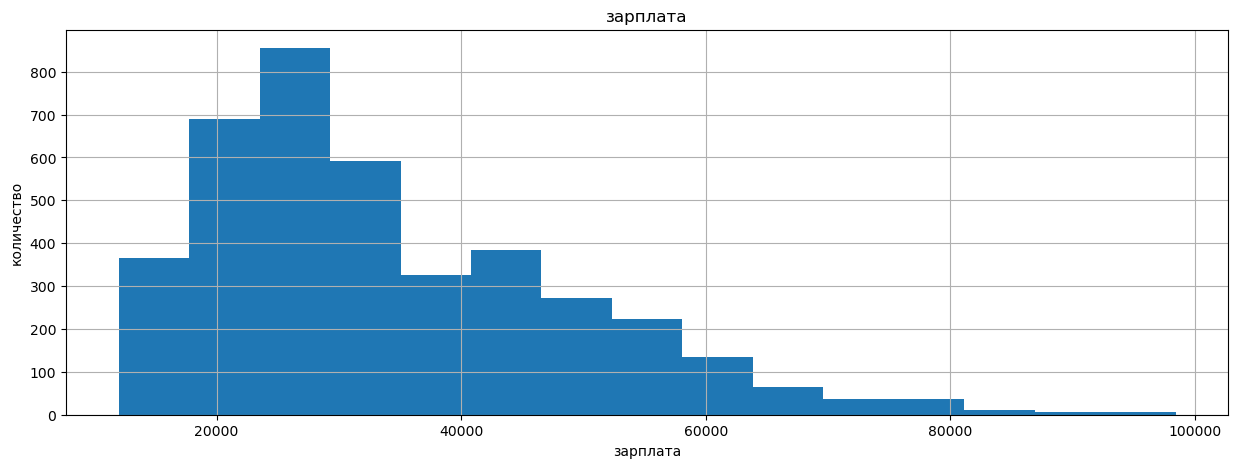

In [58]:
train_job_satisfaction_rate['salary'].hist(bins=15, figsize=(15,5))
plt.title('зарплата')
plt.ylabel('количество')
plt.xlabel('зарплата')
plt.show()

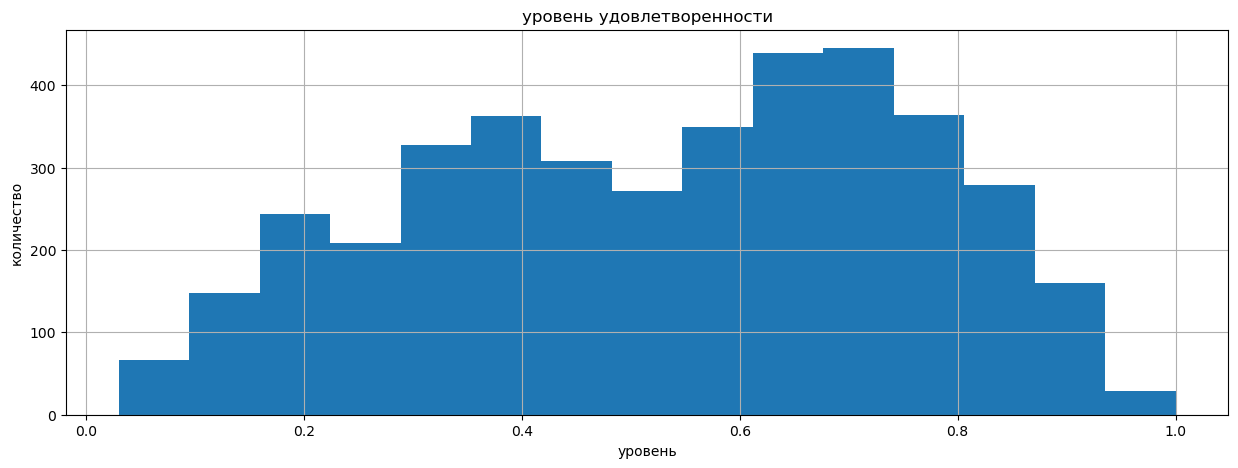

In [59]:
train_job_satisfaction_rate['job_satisfaction_rate'].hist(bins=15, figsize=(15,5))
plt.title('уровень удовлетворенности')
plt.ylabel('количество')
plt.xlabel('уровень')
plt.show()

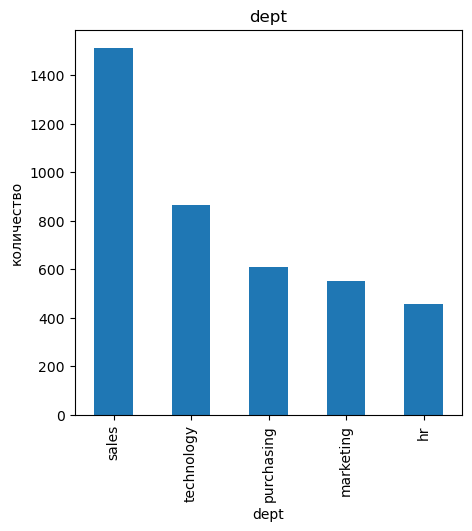

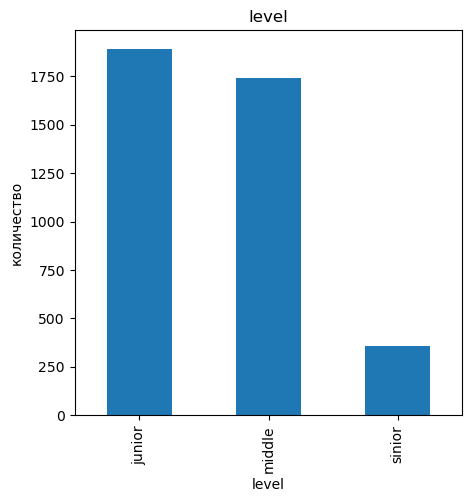

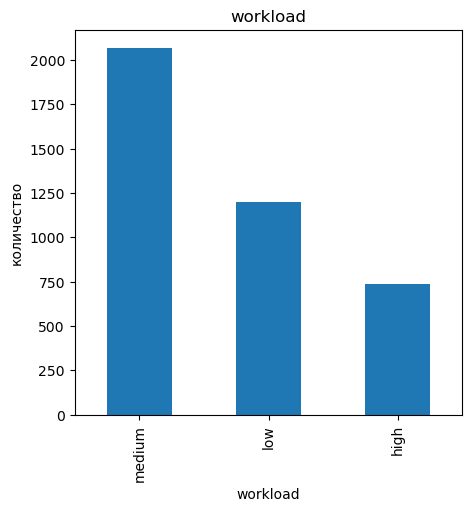

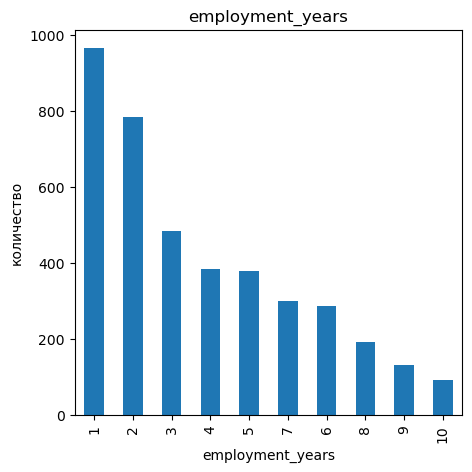

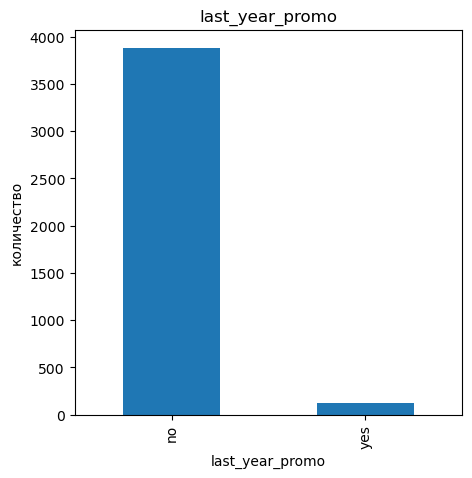

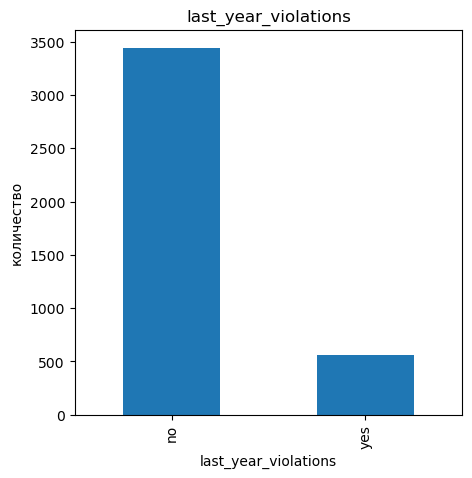

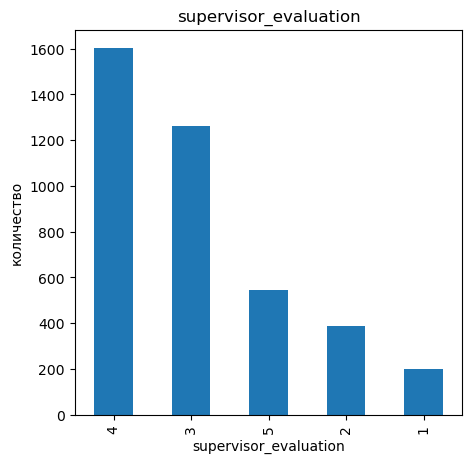

In [60]:
for i in cat:
    train_job_satisfaction_rate[i].value_counts().plot(kind='bar', figsize=(5, 5)), 
    plt.title(i),
    plt.xlabel(i),
    plt.ylabel('количество'), 
    plt.show()

Основываясь на графиках, можно сказать, что:
* среднее значение зарплаты 30000, 75% получают < 43000
* удовлетворение от работы имеет среднее значение в 0.53, но присутствуют два пика по значениям в 0.4 и 0.7
* самый популярный отдел - продаж
* одинаковое количество джуниоров и мидлов по уровню знаний
* уровень загруженности сотрудников в основном средний, повышенная нагрузка составляет около 20%
* длительность работы в компании линейно уменьшается со значения в 1 год
* в основном за последний год никого не повышают в должности
* 12% нарушали трудовой договор за последний год
* в основном все сотрудники получают хорошую либо удовлетворительную оценку за работу

In [66]:
interval_cols = ['salary', 'job_satisfaction_rate']
phik_overview = phik_matrix(train_job_satisfaction_rate.drop('id', axis=1), interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='корреляция',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Высокая корреляция у признаков:
* supervisor_evaluation / job_satisfaction_rate
* workload / salary
* level / salary

Заметная корреляция у признаков:
* last_year_violations / job_satisfaction_rate
* level / employment_years

Умеренная корреляция у признаков:
* employment_years / job_satisfaction_rate
* employment_years / salary
* level / workload

У остальных признаков слабая корреляция

#### test_features 

In [69]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [71]:
test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [72]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [73]:
num = ['salary', 'job_satisfaction_rate']
cat = ['dept', 'level', 'workload', 'employment_years', 
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation']

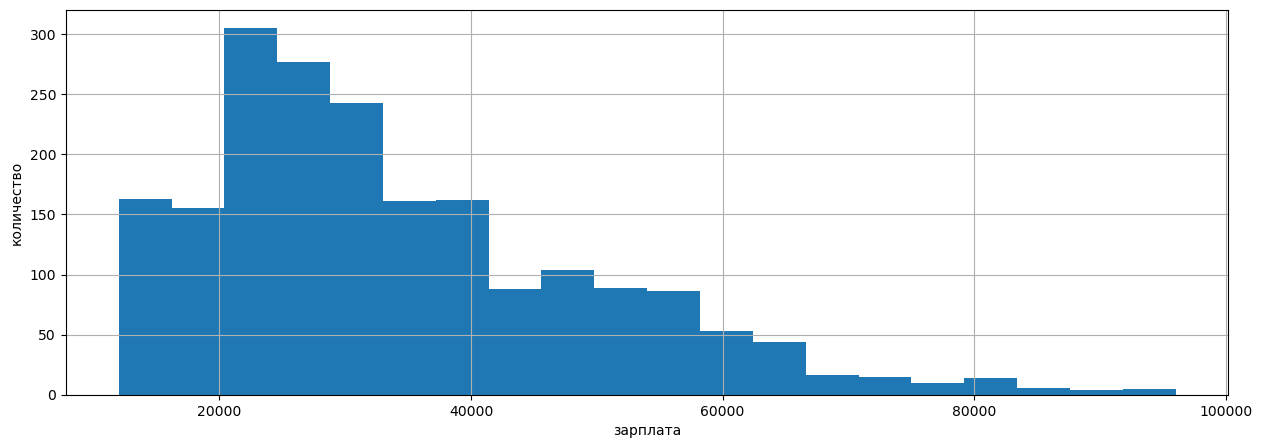

In [138]:
test_features['salary'].hist(bins=20, figsize=(15,5))
plt.xlabel('зарплата')
plt.ylabel('количество')
plt.show()

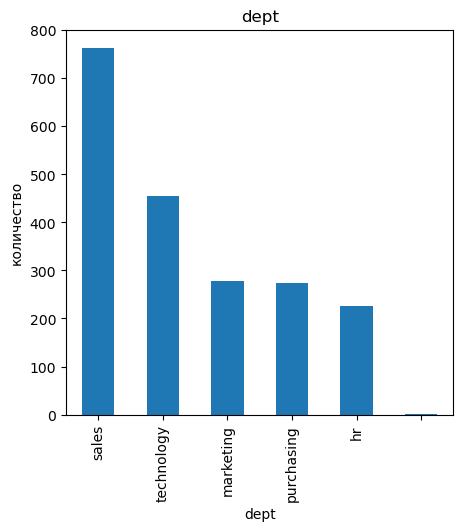

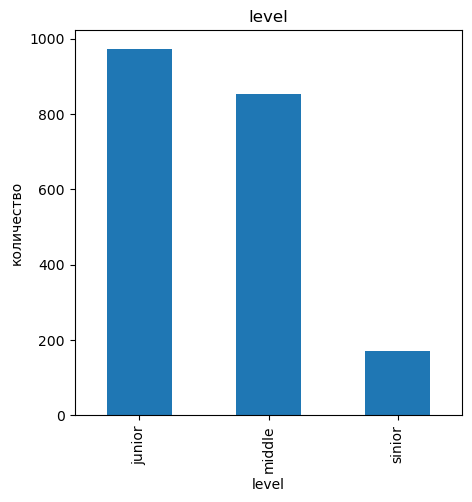

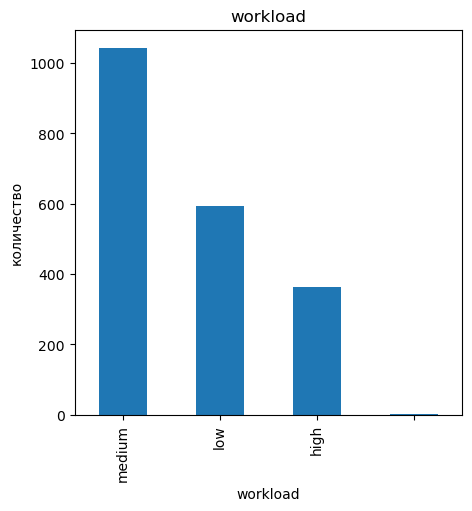

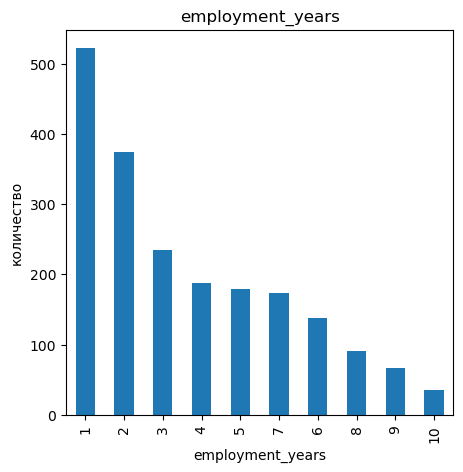

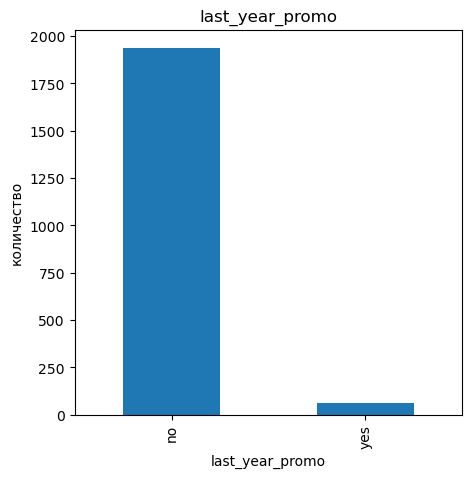

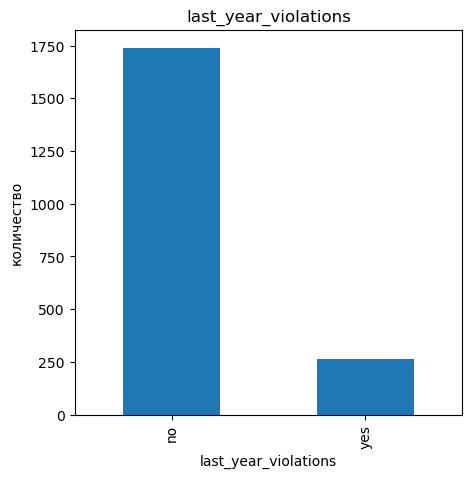

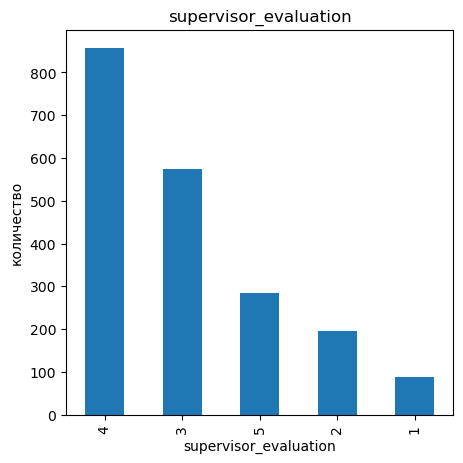

In [75]:
for i in cat:
    test_features[i].value_counts().plot(kind='bar', figsize=(5, 5)), 
    plt.title(i),
    plt.xlabel(i),
    plt.ylabel('количество'), 
    plt.show()

Основываясь на графиках, можно сказать, что:
* среднее значение зарплаты 30000
* самый популярный отдел - продаж
* примерно одинаковое количество джуниоров и мидлов по уровню знаний
* уровень загруженности сотрудников в основном средний
* в основном за последний год никого не повышают в должности
* 12% нарушали трудовой договор за последний год
* в основном все сотрудники получают хорошую либо удовлетворительную оценку за работу

In [77]:
interval_cols = ['salary', 'employment_years']
phik_overview = phik_matrix(test_features.drop('id', axis=1), interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='корреляция',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Высокая корреляция у признаков:
* workload / salary
* level / salary

Заметная корреляция у признаков:
* level / employment_years

Умеренная корреляция у признаков:
* employment_years / salary

У остальных признаков слабая корреляция

#### test_target_job_satisfaction_rate 

In [80]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


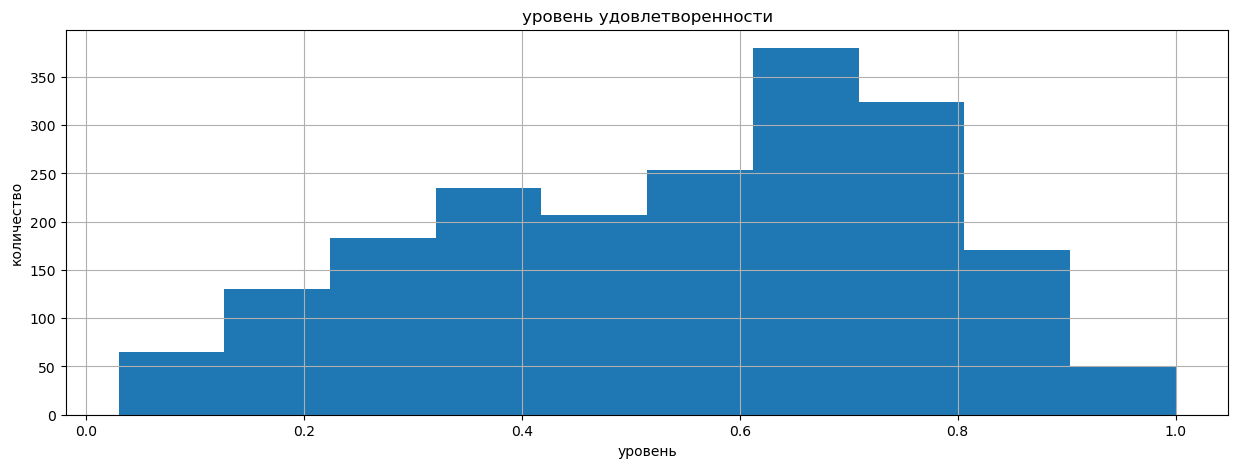

In [140]:
test_target_job_satisfaction_rate['job_satisfaction_rate'].hist(figsize=(15, 5))
plt.title('уровень удовлетворенности')
plt.xlabel('уровень')
plt.ylabel('количество')
plt.show()

Больше всего значений от 0.6 до 0.7

### Шаг 4. Подготовка данных

In [84]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [142]:
X_train = train_job_satisfaction_rate.drop(columns=['id', 'workload', 'last_year_promo'], axis=1)

In [144]:
X_train = X_train.drop_duplicates()

In [146]:
y_train = X_train['job_satisfaction_rate']

In [150]:
X_train = X_train.drop('job_satisfaction_rate', axis=1)

In [152]:
test_prep = test_features.merge(test_target_job_satisfaction_rate)
test_prep.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [154]:
X_test = test_prep.drop(columns=['id', 'job_satisfaction_rate', 'workload', 'last_year_promo'], axis=1)
y_test = test_prep['job_satisfaction_rate']

In [156]:
ohe_columns = [
    'last_year_violations',
    'dept'
]
ord_columns = [
    'level',
]

In [160]:
num_columns = [
               'salary'
] 

In [161]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop = 'first', handle_unknown='ignore'))
    ]
    )

In [165]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [166]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Шаг 5. Обучение моделей

In [168]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [172]:
param_grid = [
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [173]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [177]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [178]:
grid = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
grid.fit(X_train, y_train)

C:\anaconda\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['last_year_violations',
                                                                                'dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_or...
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(2, 20),
                                         'models__max_features': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [179]:
print('Значение метрики:', abs(grid.best_score_))
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)

Значение метрики: 16.998644378959604
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                 

In [183]:
y_pred = grid.predict(X_test)

C:\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [184]:
smape(y_test, y_pred)

14.868337064538492

В результате работы был создан пайплайн, в котором лучшей моделью была выбрана модель DecisionTreeRegressor(max_depth=13, max_features=15, random_state=42). Значение smape на тестовой выборке составляет 14.86.

## Задача 2

### Шаг 1. Загрузка данных

In [194]:
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

#### train_quit

In [196]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [197]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Таблица содержит 4000 строк с информацией об условиях труда работника без пропусков. Это тренировочная выборка с входными и целевым признаками

#### test_features

In [200]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [201]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Таблица содержит 2000 строк, некоторые имеют пропуски

#### test_target_quit

In [204]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [205]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Таблица содержит 2000 целевых значений, пропусков нет.

### Шаг 2. Предобработка данных

#### train_quit

In [209]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [210]:
train_quit.duplicated().sum()

0

In [211]:
for column in train_quit.columns:
    print(train_quit[column].unique())

[723290 814010 155091 ... 536432 692133 853842]
['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
[ 2  5  1  8  4  7  3  9  6 10]
['no' 'yes']
['no' 'yes']
[4 1 3 5 2]
[54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200 48000
 43200 73200 31200 78000 64800 72000 94800 96000 63600 79200 55200 42000
 49200 50400 14400 13200 51600 67200 88800 68400 69600 70800 84000 81600
 87600 75600 91200 76800 74400 80400 85200 86400 92400]
['no' 'yes']


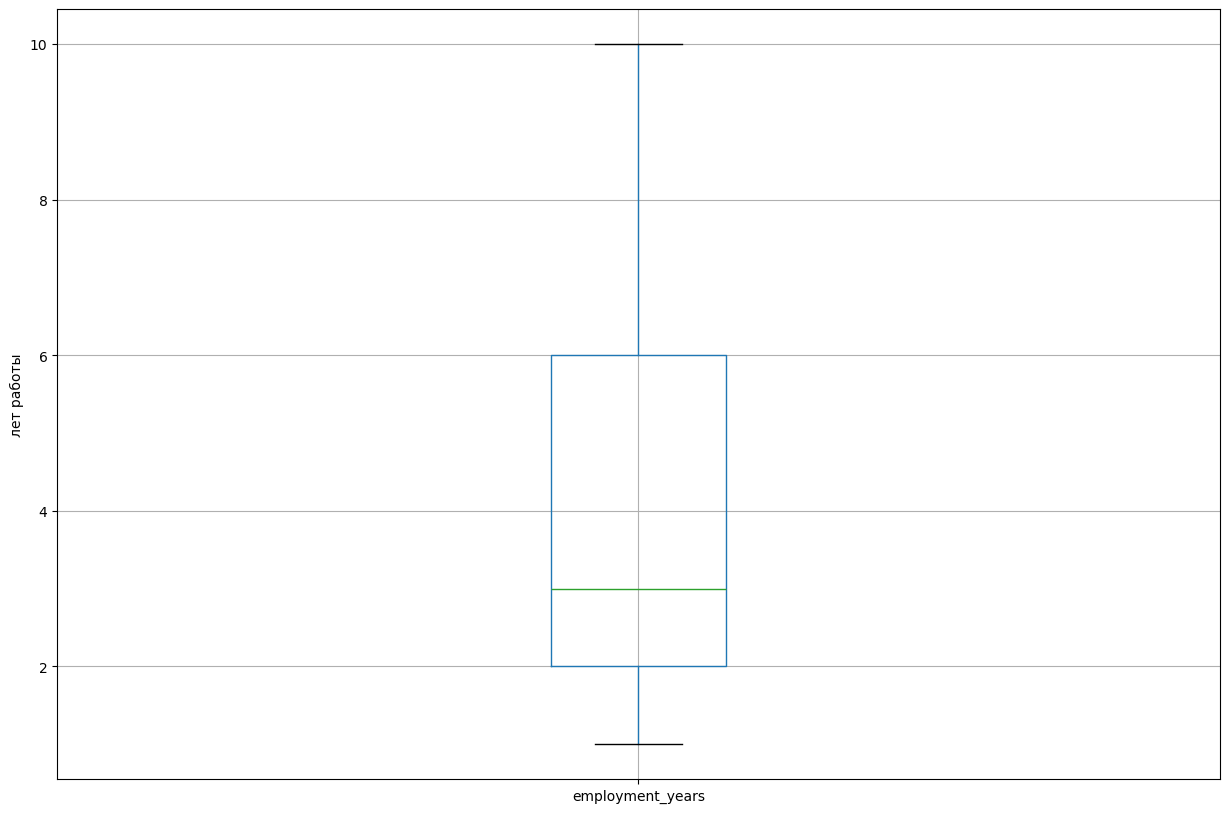

In [212]:
train_quit.boxplot(column='employment_years')
plt.ylabel('лет работы')
plt.show()

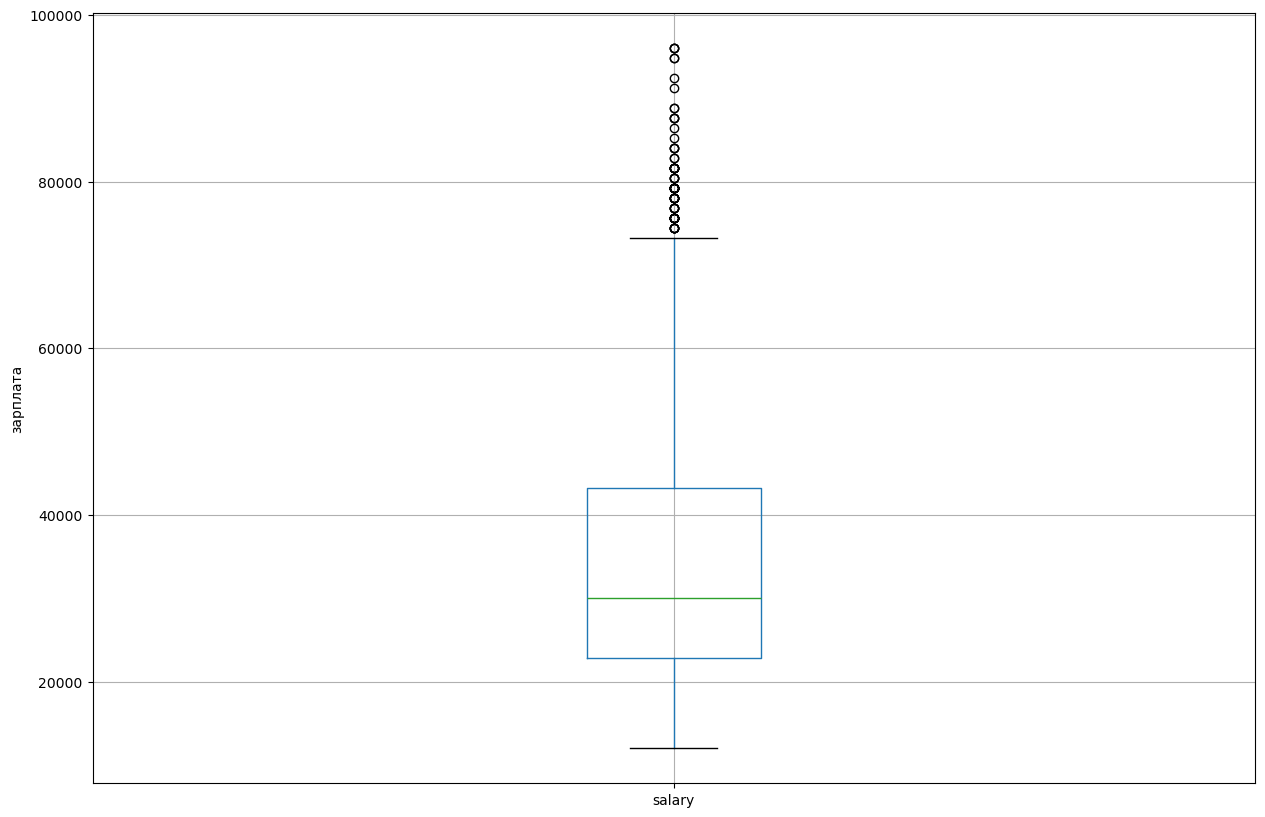

In [213]:
train_quit.boxplot(column='salary')
plt.ylabel('зарплата')
plt.show()

In [214]:
train_quit.query('salary > 75000').count()/train_quit['salary'].count()

id                       0.018
dept                     0.018
level                    0.018
workload                 0.018
employment_years         0.018
last_year_promo          0.018
last_year_violations     0.018
supervisor_evaluation    0.018
salary                   0.018
quit                     0.018
dtype: float64

In [215]:
train_quit = train_quit.query('salary < 75000')

#### test_features

In [217]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [218]:
test_features.duplicated().sum()

0

In [219]:
for column in test_features.columns:
    print(test_features[column].unique())

[485046 686555 467458 ... 305653 160233 771859]
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
[ 2  1  5  6  3  9  7  4  8 10]
['no' 'yes']
['no' 'yes']
[5 4 3 1 2]
[28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]


In [220]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [221]:
work = ['medium', 'low', 'high']

In [222]:
test_features = test_features.query('workload in @work')

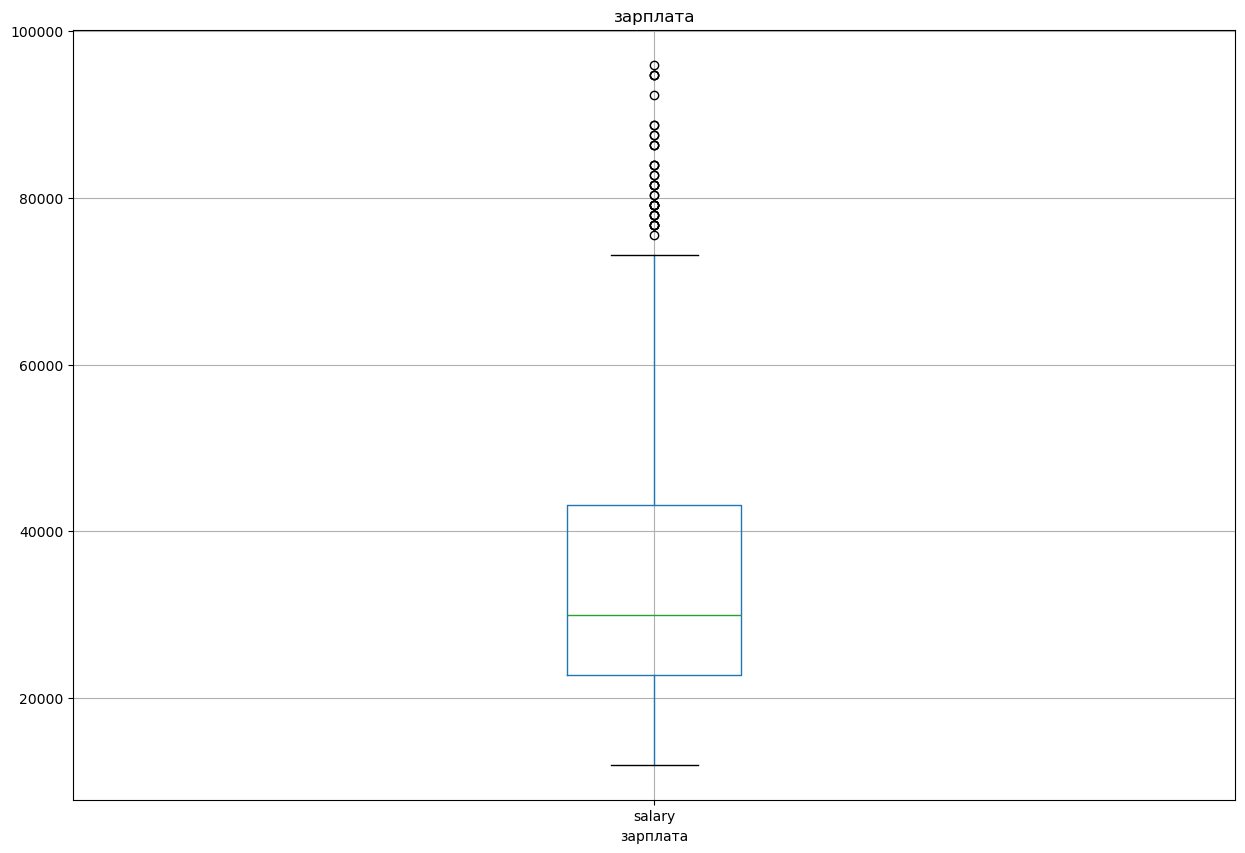

In [223]:
test_features.boxplot(column='salary')
plt.title('зарплата')
plt.xlabel('зарплата')
plt.show()

#### test_target_quit

In [226]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [227]:
test_target_quit.duplicated().sum()

0

In [228]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

#### Вывод

В ходе предобработки были проверены пропуски, аномалии, типы данных, в одной из таблиц была исправлена ошибка

### Шаг 3. Исследовательский анализ данных

#### train_quit

In [233]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [234]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,3928.000000,3928.000000,3928.000000,3928.000000
mean,553236.983707,3.660387,3.471741,32936.761711
std,260333.891716,2.518025,1.007593,13830.435649
min,100222.000000,1.000000,1.000000,12000.000000
25%,328077.250000,2.000000,3.000000,22800.000000
50%,549295.500000,3.000000,4.000000,30000.000000
75%,782608.000000,5.000000,4.000000,42000.000000
max,999915.000000,10.000000,5.000000,74400.000000


In [235]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3928 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     3928 non-null   int64 
 1   dept                   3928 non-null   object
 2   level                  3928 non-null   object
 3   workload               3928 non-null   object
 4   employment_years       3928 non-null   int64 
 5   last_year_promo        3928 non-null   object
 6   last_year_violations   3928 non-null   object
 7   supervisor_evaluation  3928 non-null   int64 
 8   salary                 3928 non-null   int64 
 9   quit                   3928 non-null   object
dtypes: int64(4), object(6)
memory usage: 337.6+ KB


In [236]:
num = ['salary']
cat = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 
       'last_year_violations', 'quit', 'supervisor_evaluation']

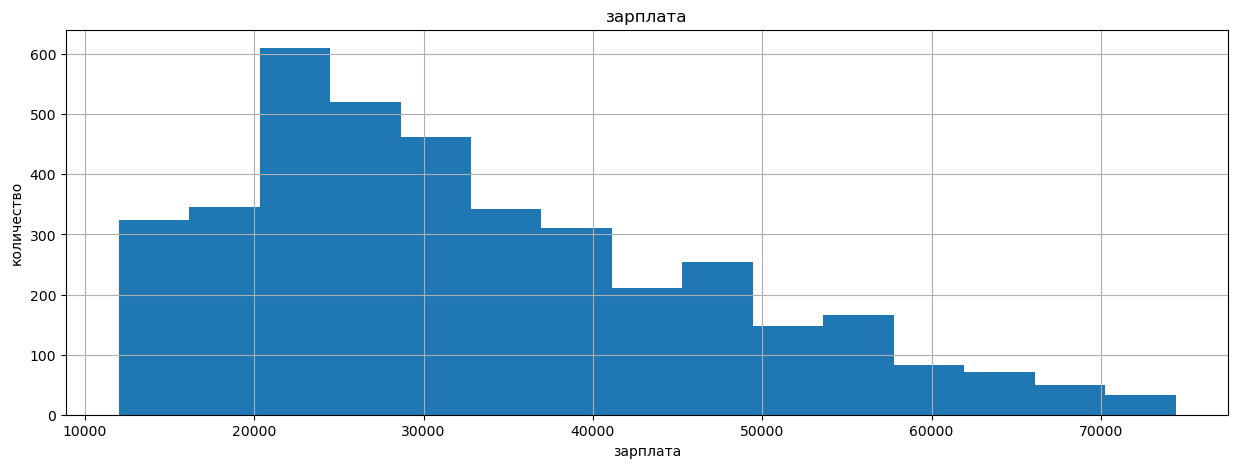

In [237]:
train_quit[num].hist(bins=15, figsize=(15,5))
plt.title('зарплата')
plt.xlabel('зарплата')
plt.ylabel('количество')
plt.show()

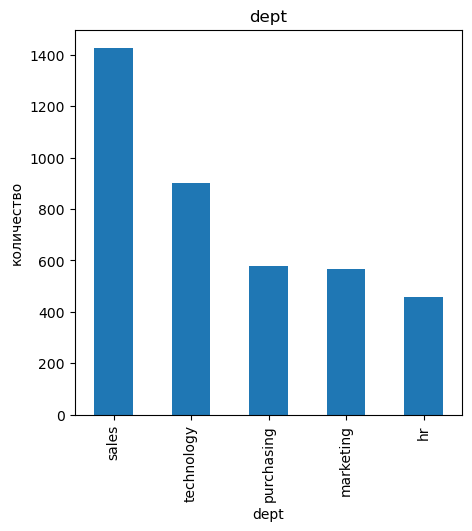

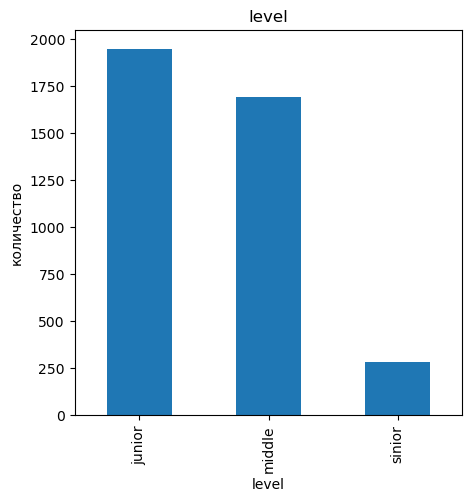

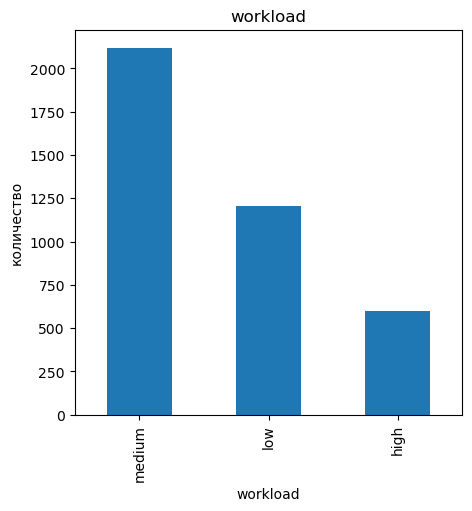

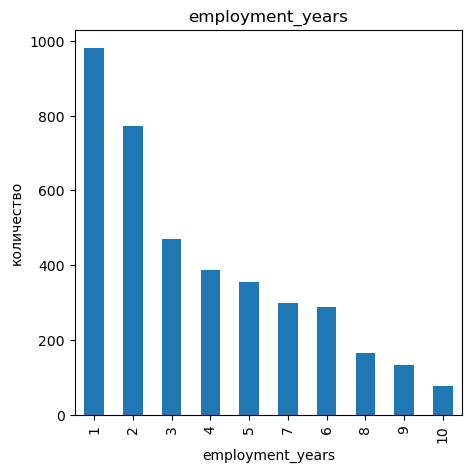

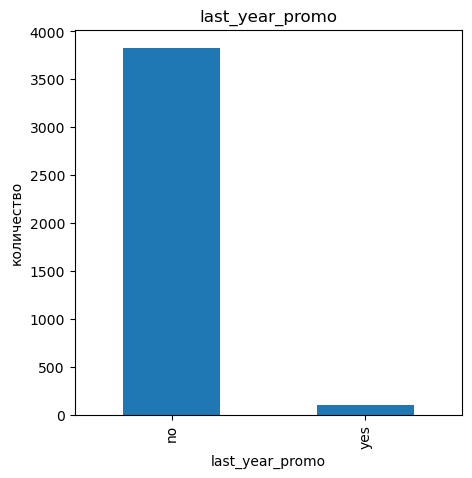

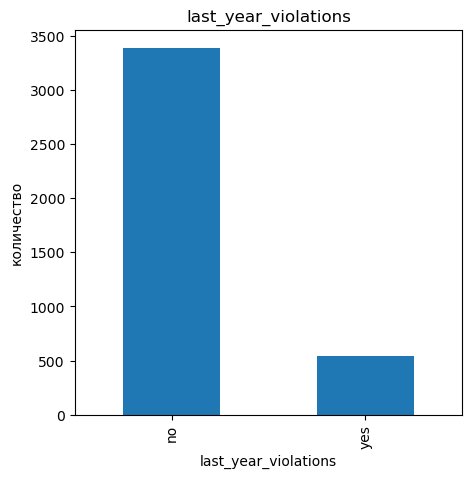

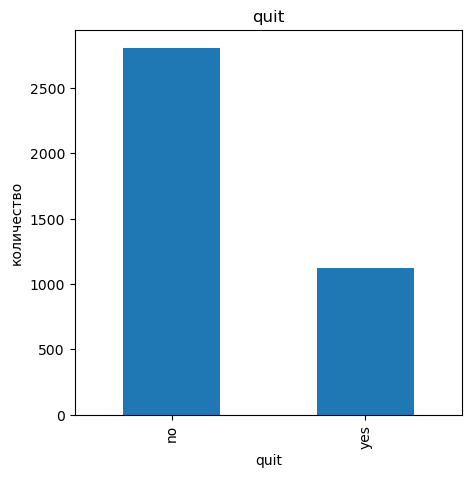

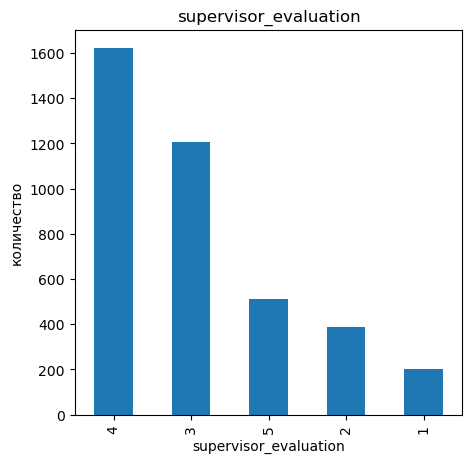

In [238]:
for i in cat:
    train_quit[i].value_counts().plot(kind='bar', figsize=(5, 5)), 
    plt.title(i),
    plt.xlabel(i),
    plt.ylabel('количество'), 
    plt.show()

Основываясь на графиках, можно сказать, что:
* среднее значение salary 33000
* основная часть работников в отделе продаж
* большая часть джуниор и мидл
* длительность работы в компании линейно уменьшается со значения в 1 год
* уровень загруженности сотрудников в основном средний
* в основном все сотрудники получают хорошую либо удовлетворительную оценку за работу

In [240]:
interval_cols = ['salary', 'employment_years']
phik_overview = phik_matrix(train_quit.drop('id', axis=1), interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title='корреляция',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Высокая корреляция у признаков:
* workload / salary
* level / salary

Заметная корреляция у признаков:
* salary / quit
* level / employment_years
* employment_years / quit

Умеренная корреляция у признаков:
* level / quit
* employment_years / salary
* level / workload

У остальных признаков слабая корреляция

#### test_features

Так как test_feature идентичны с прошлой задачей, то:

Основываясь на графиках, можно сказать, что:
* среднее значение зарплаты 30000
* самый популярный отдел - продаж
* примерно одинаковое количество джуниоров и мидлов по уровню знаний
* уровень загруженности сотрудников в основном средний
* в основном за последний год никого не повышают в должности
* 12% нарушали трудовой договор за последний год
* в основном все сотрудники получают хорошую либо удовлетворительную оценку за работу

Высокая корреляция у признаков:
* workload / salary
* level / salary

Заметная корреляция у признаков:
* level / employment_years

Умеренная корреляция у признаков:
* employment_years / salary

У остальных признаков слабая корреляция

#### test_target_quit

In [247]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


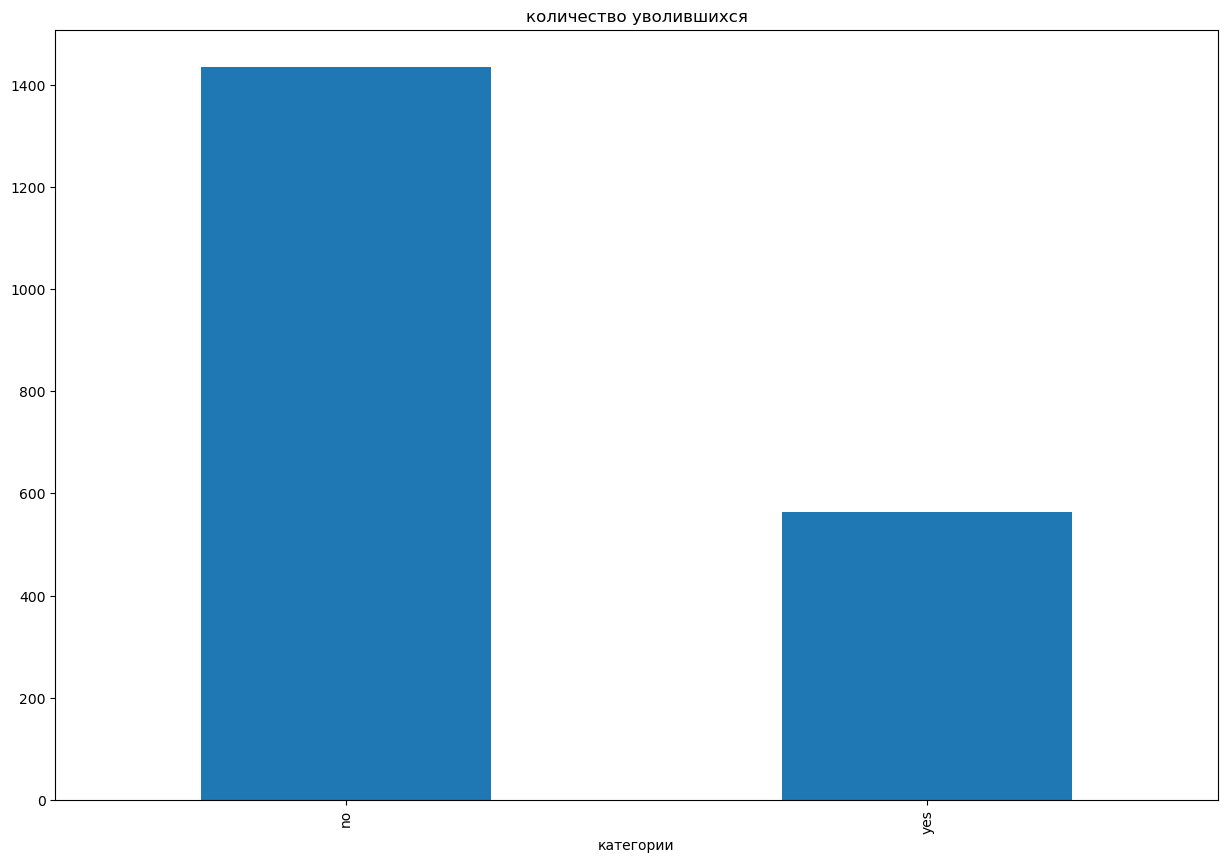

In [298]:
test_target_quit['quit'].value_counts().plot(kind='bar')
plt.title('количество уволившихся')
plt.xlabel('категории')
plt.show()

Количество оставшихся работников - 1400, уволившихся - 600

#### Портрет 

In [273]:
test_full = test_features.merge(test_target_quit)
test_full.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


In [274]:
portrait = test_full.query('quit == "yes"')
kept = test_full.query('quit =="no"')

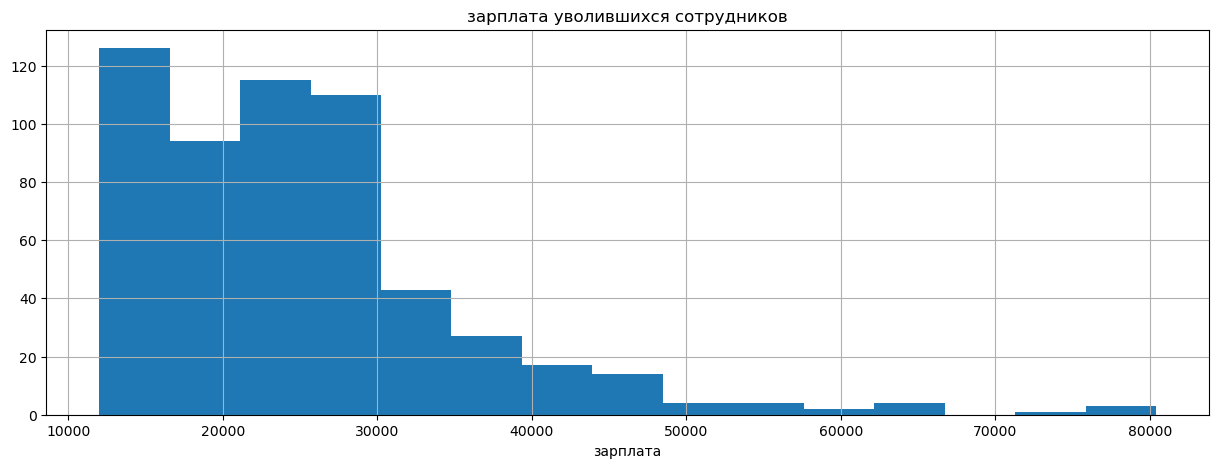

In [275]:
portrait[num].hist(bins=15, figsize=(15,5))
plt.title('зарплата уволившихся сотрудников')
plt.xlabel('зарплата')
plt.show()

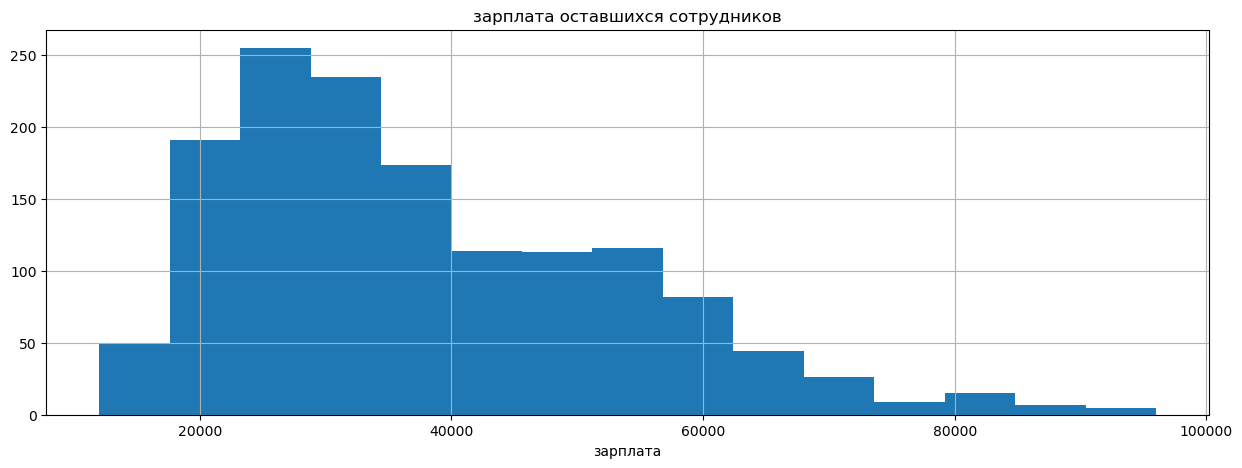

In [276]:
kept[num].hist(bins=15, figsize=(15, 5))
plt.title('зарплата оставшихся сотрудников')
plt.xlabel('зарплата')
plt.show()

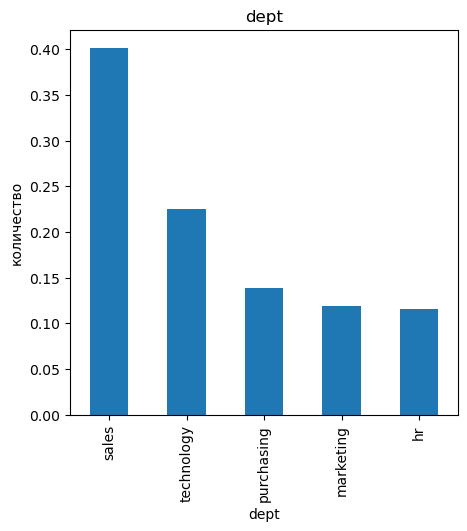

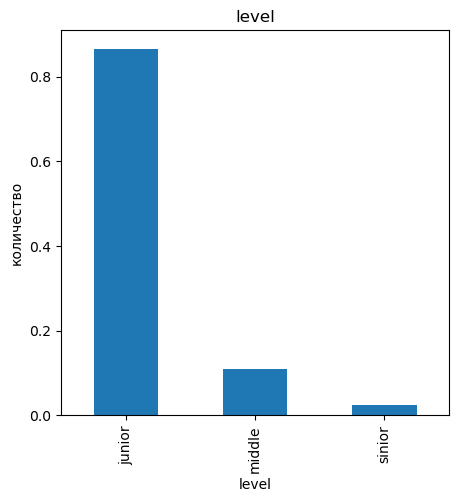

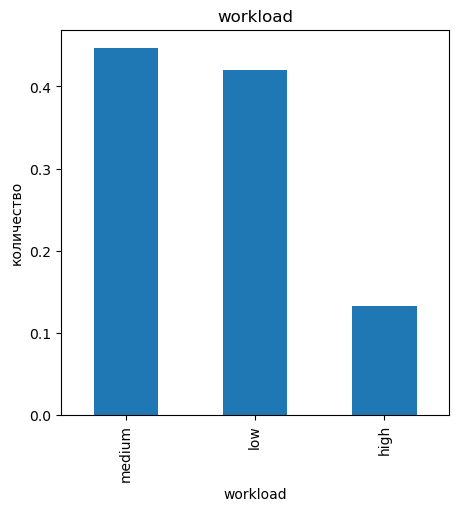

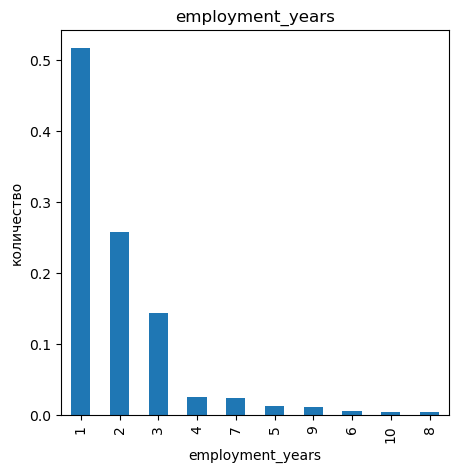

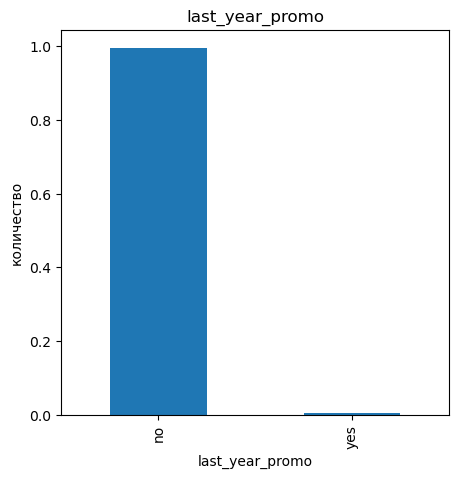

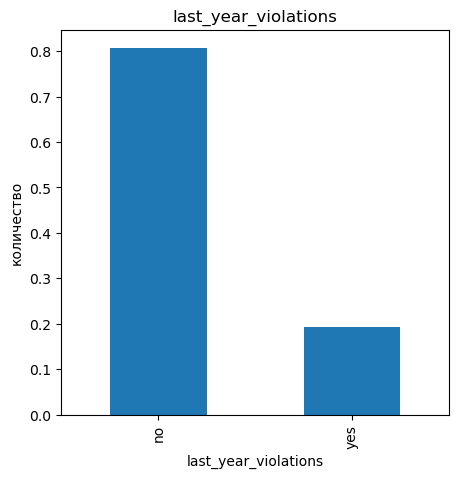

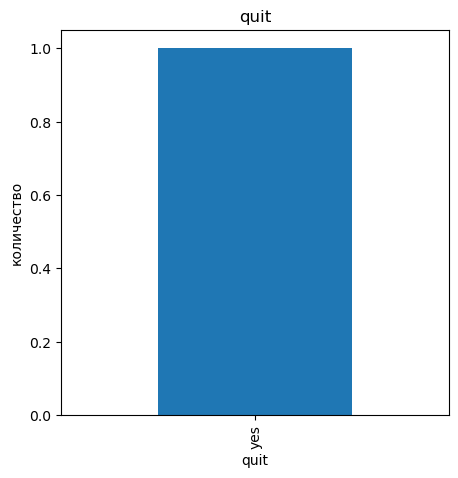

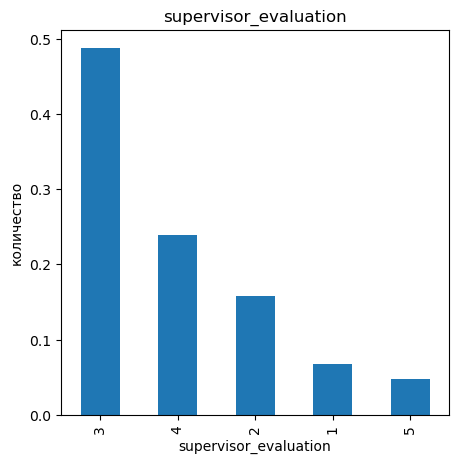

In [277]:
for i in cat:
    portrait[i].value_counts(normalize=True).plot(kind='bar', figsize=(5, 5)), 
    plt.title(i),
    plt.xlabel(i),
    plt.ylabel('количество'), 
    plt.show()

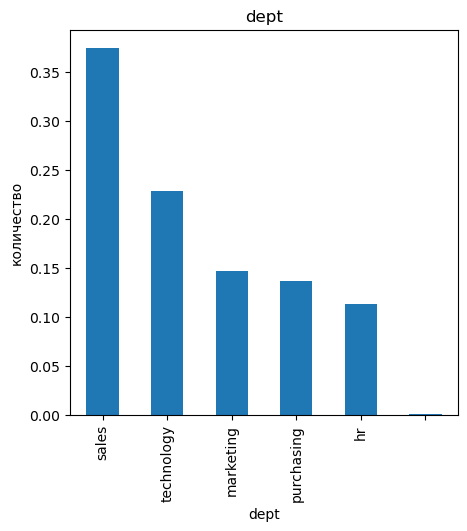

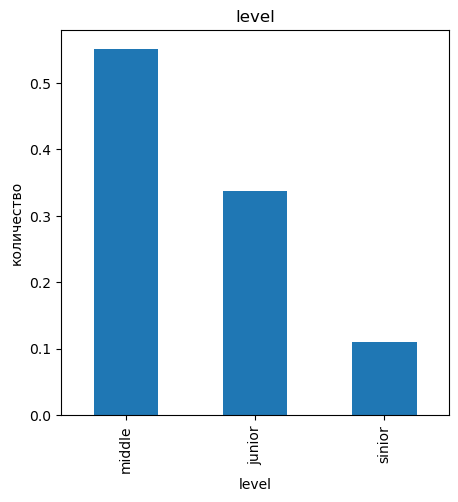

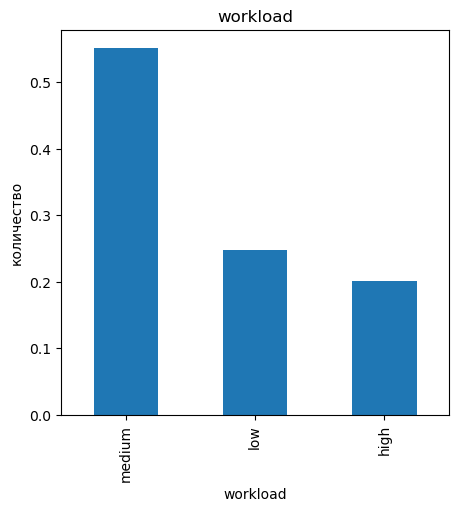

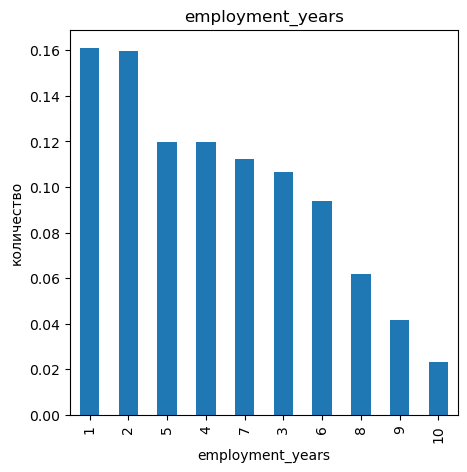

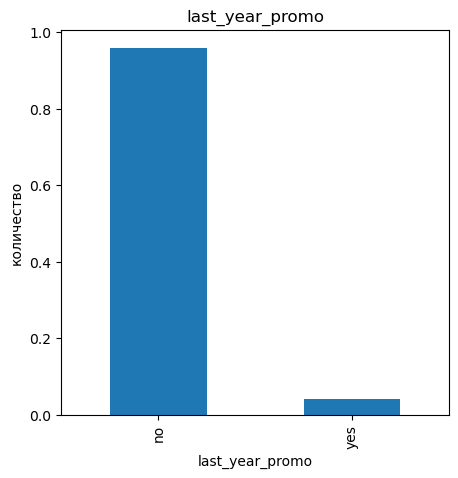

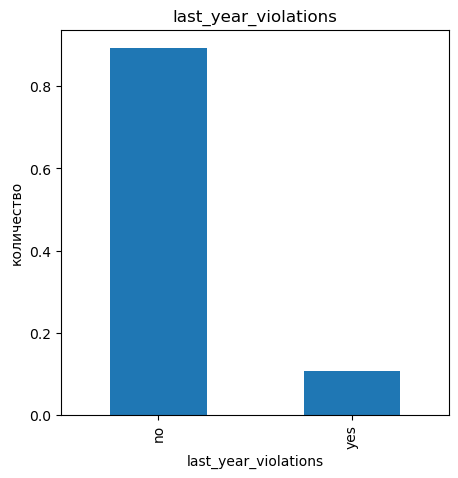

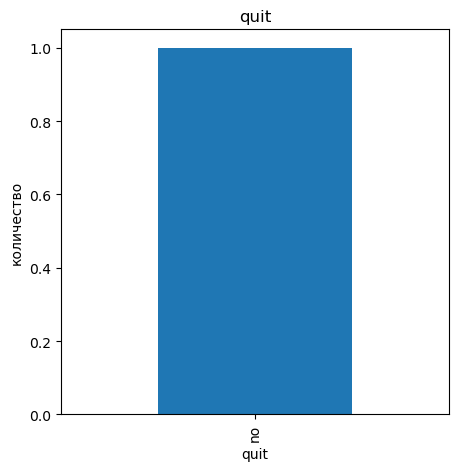

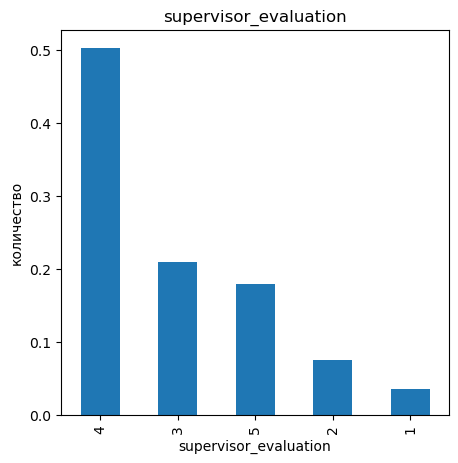

In [278]:
for i in cat:
    kept[i].value_counts(normalize=True).plot(kind='bar', figsize=(5, 5)), 
    plt.title(i),
    plt.xlabel(i),
    plt.ylabel('количество'), 
    plt.show()

In [279]:
test_full = test_full.merge(test_target_job_satisfaction_rate)
test_full.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.72
2,467458,sales,middle,low,5,no,no,4,19200,no,0.64
3,418655,sales,middle,low,6,no,no,4,19200,no,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.75


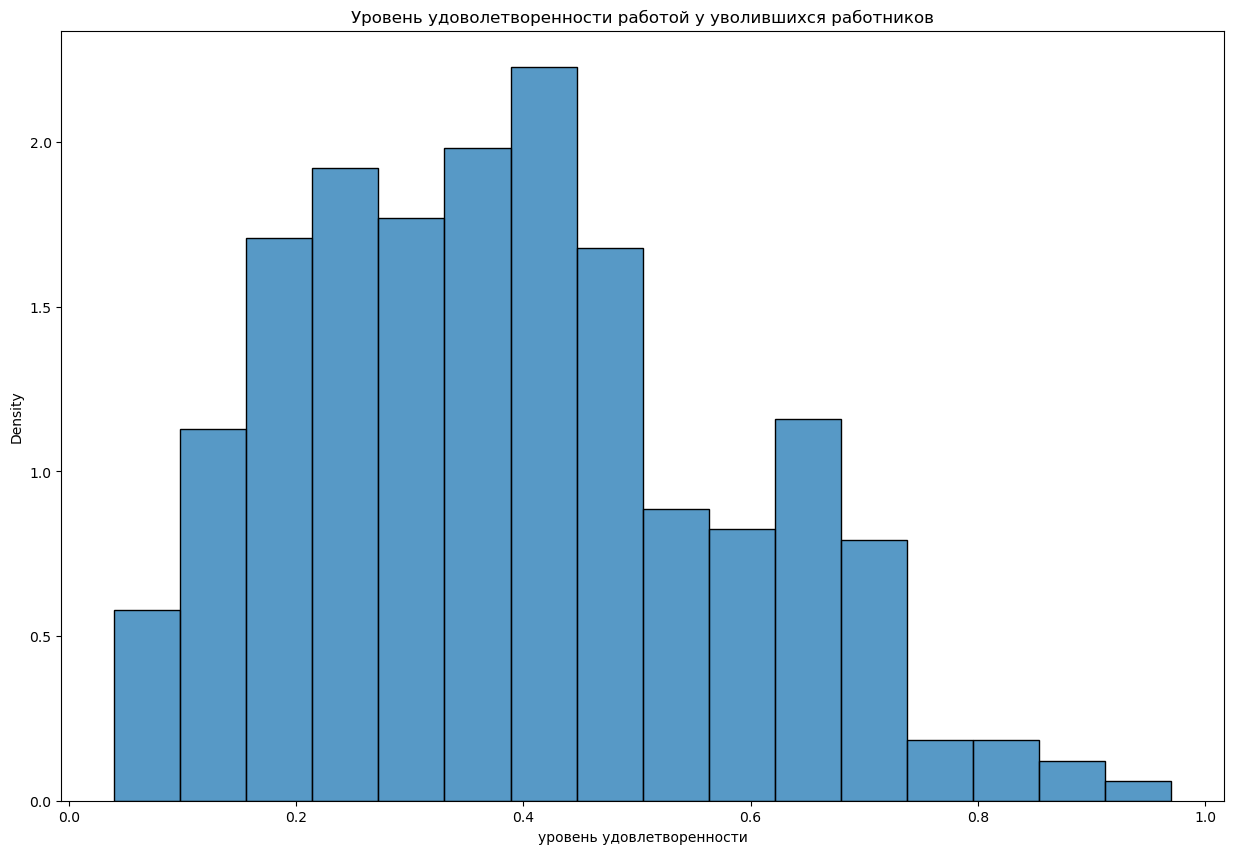

In [280]:
sns.histplot(data=(test_full.loc[test_full['quit'] == 'yes', 'job_satisfaction_rate']), stat='density', common_norm=False)
plt.title('Уровень удоволетворенности работой у уволившихся работников')
plt.xlabel('уровень удовлетворенности')
plt.show()

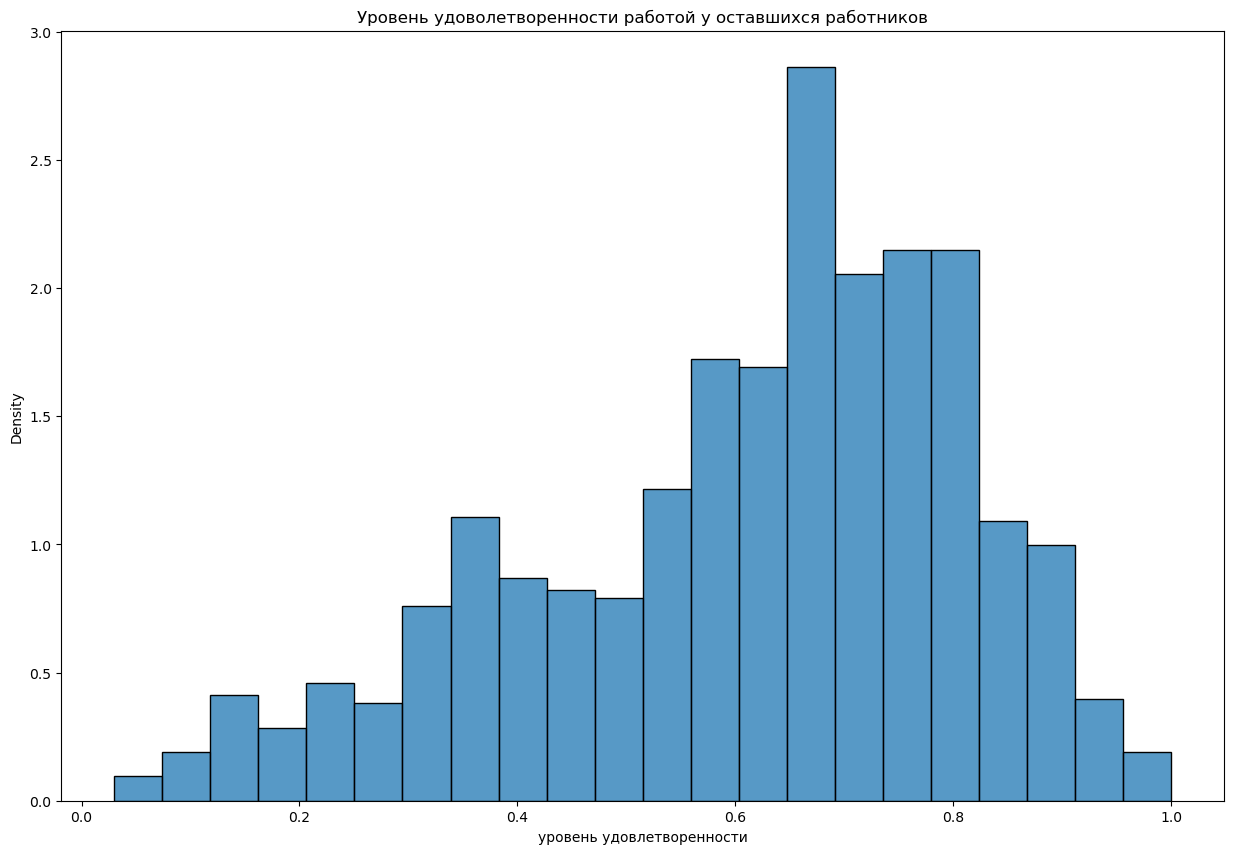

In [281]:
sns.histplot(data=(test_full.loc[test_full['quit'] == 'no', 'job_satisfaction_rate']), stat='density', common_norm=False)
plt.title('Уровень удоволетворенности работой у оставшихся работников')
plt.xlabel('уровень удовлетворенности')
plt.show()

In [282]:
(test_full.loc[test_full['quit'] == 'no', 'job_satisfaction_rate'].mean())-(test_full.loc[test_full['quit'] == 'yes', 'job_satisfaction_rate'].mean())

0.22420361034917324

У уволившихся работников уровень удовлетворенностью работой намного меньше, чем у оставшихся работников, среднее значение различается на 22 процента, причем у довольных работников пик у значения 0.7, а у уволившихся у значения 0.4

#### Вывод

Можно описать сотрудника, склонного к увольнению:
* зарплата до 30000
* работает в продажах или технологиях
* джуниор
* либо малая нагрузка, либо средняя
* работает в компании несколько лет
* не получил повышение в прошедшем году
* получал от руководства оценки 3 и 4

Оставшиеся работники - вытерпевшие джуниоры, ставшие мидлами, со стажем от двух лет, с появившимся объемом работы

### Шаг 4. Добавление нового входного признака

In [287]:
test_features2 = test_features.drop('id', axis=1)

In [288]:
test_features2['job_satisfaction_rate'] = grid.predict(test_features2)

C:\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [289]:
test_features2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.845714
1,hr,junior,medium,1,no,no,4,30000,0.664516
2,sales,middle,low,5,no,no,4,19200,0.690000
3,sales,middle,low,6,no,no,4,19200,0.713333
4,hr,middle,medium,5,no,no,5,40800,0.816316


<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Новый признак добавлен в таблицы.

### Шаг 5. Подготовка данных

In [292]:
X_train = train_quit.drop(columns=['id', 'last_year_promo'], axis=1)

In [293]:
X_train.duplicated().sum()

1450

In [294]:
X_train = X_train.drop_duplicates()
X_train.duplicated().sum()

0

In [295]:
y_train = X_train['quit']

In [296]:
X_train = X_train.drop('quit', axis=1)

In [301]:
test_prep = test_full.drop('id', axis=1)

In [303]:
X_test = test_prep.drop(columns=['last_year_promo', 'quit'], axis=1)

In [304]:
y_test = test_prep['quit']

In [312]:
label_encoder = LabelEncoder()

In [313]:
y_train = label_encoder.fit_transform(y_train)

In [314]:
y_test = label_encoder.transform(y_test)

ohe_columns = [
    'last_year_promo', 
    'last_year_violations',
    'dept'
]
ord_columns = [
    'level',
    'workload'
]
num_columns = ['employment_years',
               'salary',
               'job_satisfaction_rate'
] 

ohe_columns = [
    'last_year_promo', 
    'last_year_violations',
    'dept'
]
ord_columns = [
    'level',
    'workload'
]
num_columns = ['salary',
               'job_satisfaction_rate'
] 

In [317]:
ohe_columns = [
    'last_year_violations',
    'dept'
]
ord_columns = [
    'level',
    'workload'
]
num_columns = ['salary',
               'job_satisfaction_rate'
] 

In [318]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop = 'first', handle_unknown='ignore'))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                    ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [320]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                    ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [321]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> 
    
1. В `num_columns` не добавлен новый входной признак.
    
2. Не выполнено кодирование целевого признака - для этого стоит использовать `LabelEncoder`.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

### Шаг 6. Обучение модели

In [325]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [326]:
param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> 
    
У `SVC` нужно настроить параметр, отвечающий за работу с вероятностями, как того требует метрика `AUC-ROC`.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Учтено.

In [329]:
grid= RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
    )
grid.fit(X_train, y_train)

C:\anaconda\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['last_year_violations',
                                                                                'dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_or...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [330]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                      

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Найдена лучшая модель.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Не выполнена оценка итоговой модели на `test`.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Давай вспомним, что из себя представляет метрика `AUC-ROC` и подходит ли метод `predict` для её оценки?

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Не достигнуто требуемое качество модели `AUC-ROC >= 0.91`.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.4 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [336]:
y_pred = grid.predict_proba(X_test)

C:\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [337]:
roc_auc = roc_auc_score(y_test, y_pred[:,1])
print('Метрика roc_auc на тестовой выборке:', roc_auc)

Метрика roc_auc на тестовой выборке: 0.9179547532557393


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Аналогично стоит выполнить оценку модели на адеватность - в случае задачи классификации мы можем использовать  `DummyClassifier` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier).
        

Лучшая модель DecisionTreeClassifier(max_depth=4, max_features=9, random_state=42), со значением 0.917 roc_auc на тестовой выборке

## Общий вывод

Основываясь на графиках, можно сказать, что:
* среднее значение зарплаты 30000, 75% получают < 43000
* удовлетворение от работы имеет среднее значение в 0.53, но присутствуют два пика по значениям в 0.4 и 0.7
* самый популярный отдел - продаж
* одинаковое количество джуниоров и мидлов по уровню знаний
* уровень загруженности сотрудников в основном средний, повышенная нагрузка составляет около 20%
* длительность работы в компании линейно уменьшается со значения в 1 год
* в основном за последний год никого не повышают в должности
* 12% нарушали трудовой договор за последний год
* в основном все сотрудники получают хорошую либо удовлетворительную оценку за работу

Необходимо было решить две задачи:
* задача 1: предсказание уровня удовлетворённости сотрудника
* задача 2: предсказание увольнения сотрудника из компании

Для решения этих задач была проведена предобработка данных, а так же исследовательский анализ данных, в ходе которого выяснилось, что:
* среднее значение зарплаты 30000
* самый популярный отдел - продаж
* большое количество джунов и мидлов
* подавляющее количество людей не повышали в должности
* в основном, работа для выполнения не требует особых усилий

Так же был составлен портрет человека, склонного к увольнению:
* зарплата до 30000
* работает в продажах или технологиях
* джуниор
* либо малая нагрузка, либо средняя
* работает в компании несколько лет
* не получил повышение в прошедшем году
* получал от руководства оценки 3 и 4
* уровень удовлетворенности достаточно мал

Для получения этих данных, были обучены 2 модели, для решения задачи регрессии и классификации:
* В задаче регрессии из двух, лучшей оказалась модель DecisionTreeRegressor(max_depth=13, max_features=15, random_state=42)
* В задаче классификации лучшей из четырех оказалась модель  DecisionTreeClassifier(max_depth=4, max_features=9, random_state=42)

В соответствии с исследованием, для того чтобы снизить уровень увольнений, необходимо:
* увеличить нагрузку для джуниоров, для того, чтобы у них была возможность улучшать свои навыки на реальных данных. Это будет способствовать скорейшему повышению, возможности получать более высокую зарплату
* обратить внимание на повышение уровня удовлетворенности, возможно, ввести какую-либо активность

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Есть итоговый вывод - отлично!

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

По результатам работы над проектом нужно сделать рекомендации для бизнеса по снижению уровня увольнений.

<div class="alert alert-success">
    
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Степан, проект получился на довольно хорошем уровне - отличная работа над проектом, молодец!

Мне нравится твой аналитический подход к выполнению проекта, ты соблюдаешь структуру работы, выполняешь её последовательно - это очень хорошо! Шаги проекта выполнены по порядку согласно плану проекта, нет смысловых и структурных ям. Важно, что не забываешь про выводы.

Работа с моделями также выполнена отлично: исследовано несколько алгоритмов, проведён подбор гиперпараметров с помощью `GridSearchCV`, выполнена промежуточная оценка моделей на кросс-валидации - молодец! Здорово, что используешь сочетание `ColumnTransformer` и `Pipeline` для соединения разных инструментов в единый модельный объект и настраиваешь бесперебойную работу энкодера в случае появления в данных новых, неизвестных на момент обучения значений признаков - так твоё решение будет более гибким и масштабируемым. 
    
Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.
    
Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)
    
Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)

Привет! 
Спасибо за содержательное ревью, с помощью комментариев узнал для себя новые моменты, касательно инструментов и функций, постарался исправить ошибки и некоторые недочеты

<div class="alert alert-success">
    
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Рад, что было полезно:) Осталась пара моментов, и мы у финиша:)

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: итоговый вывод по проекту.

Степан, все замечания учтены - проект принят!
    
Спасибо за хорошую работу над проектом, желаю успехов в дальнейшем обучении:)